In [2]:
%run "imports.ipynb"

In [3]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

In [4]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.32.1.246:34497 Dashboard: /user/carlo%20mariade%20marco1/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
ac_biallel = zarr.open('data/phase2_biallel_allele_count.zarr')
callset = callset_biallel
annotation = callset_anno

In [6]:
contigs = ['2R','2L','3R','3L', 'X']

In [ ]:
ann = {chrom: annotation[chrom]['variants/ANN_Annotation'][:] for chrom in contigs}
ann

In [ ]:
pos = {chrom: callset[chrom]['variants/POS'][:] for chrom in contigs}
pos

----------------------------------------------

In [7]:
def pbs(chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    
    # load variant positions
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    pos = callset[chrom]['variants/POS'][:][loc_pass_variants]
    
    # load allele counts
    ac1 = allel.AlleleCountsArray(ac_biallel[chrom][pop1])
    ac2 = allel.AlleleCountsArray(ac_biallel[chrom][pop2])
    ac3 = allel.AlleleCountsArray(ac_biallel[chrom][pop3])

    # locate segregating variants at sufficient frequency
    ac = ac1 + ac2 + ac3
    loc_seg = (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    pos = pos[loc_seg]
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    
    # setup windows
    starts = allel.moving_statistic(pos, statistic=lambda v: v[0], size=window_size)
    starts[0] = 1  # fix to start of sequence
    ends = np.append(starts[1:] - 1, [np.max(pos)])

    # compute pbs
    res = allel.pbs(ac1, ac2, ac3, window_size=window_size, normed=normed)

    return starts, ends, res

def pbs_plot (chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    starts, ends, y = pbs(chrom, pop1, pop2, pop3)
    fig, ax = plt.subplots(figsize=(14, 3))
    x = (starts + ends) / 2
    sns.despine(ax=ax, offset=10)
    ax.set_xlim(0, x.max())
    ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
    ax.set_xlabel('Genome position (bp)')
    ax.set_ylabel('PBS');

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


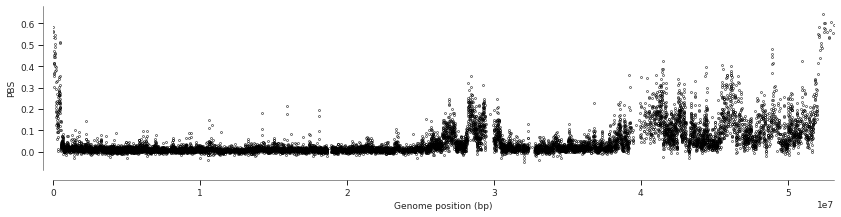

In [8]:
pbs_plot('3R', 'BFcol', 'BFgam', 'FRgam')

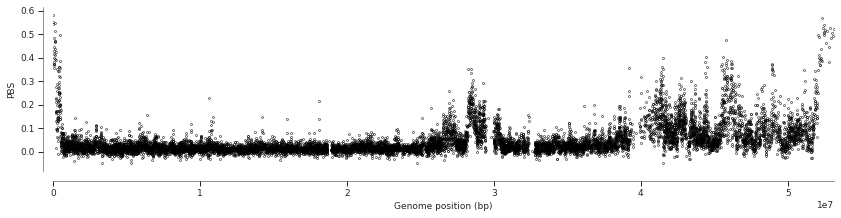

In [57]:
pbs_plot('3R', 'GHcol', 'GHgam', 'FRgam')

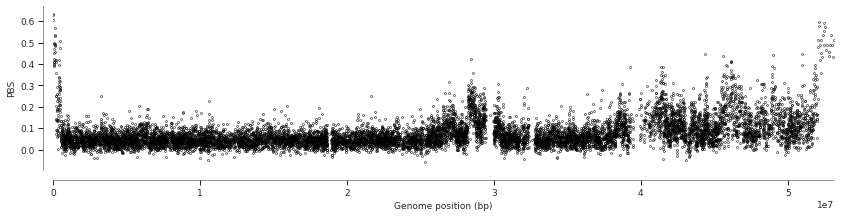

In [58]:
pbs_plot('3R', 'GNcol', 'GNgam', 'FRgam')

-------------------------------------------------------------

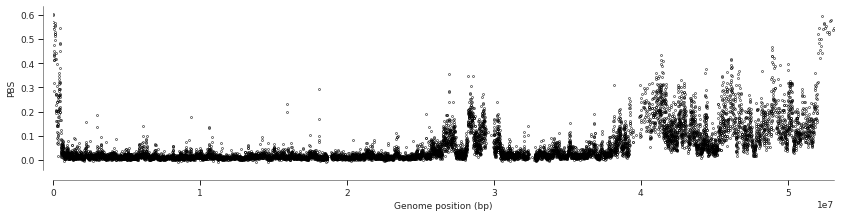

In [59]:
pbs_plot('3R', 'BFcol', 'BFgam', 'GAgam')

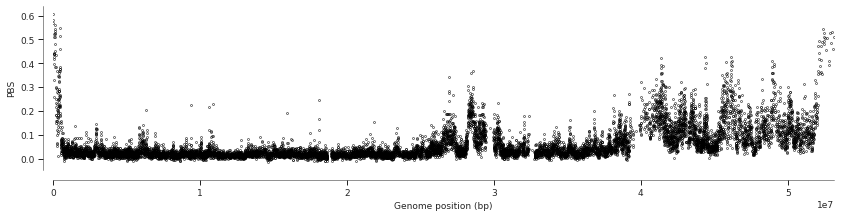

In [60]:
pbs_plot('3R', 'GHcol', 'GHgam', 'GAgam')

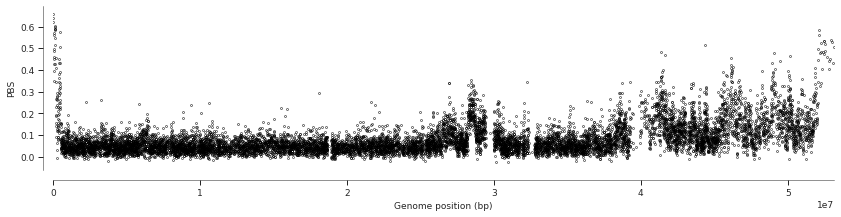

In [61]:
pbs_plot('3R', 'GNcol', 'GNgam', 'GAgam')

-------------------------------------

## Sandbox - First time

In [8]:
pop_select = metadata.population.isin({'BFgam', 'BFcol', 'AOcol'}).values
pop_subset=metadata[pop_select]

In [9]:
genotypes_phase2_call = callset_phase2['3L']["calldata/GT"]
genotypes_phase2_call

<zarr.core.Array '/3L/calldata/GT' (10640388, 1142, 2) int8 read-only>

In [62]:
pos = allel.SortedIndex(callset_phase2["3L"]["variants/POS"])
pos

0,1,2,3,4,...,10640383,10640384,10640385,10640386,10640387
9790,9791,9798,9812,9815,...,41956532,41956537,41956541,41956551,41956556


In [11]:
genotypes_phase2 = allel.GenotypeDaskArray(genotypes_phase2_call)
genotypes_phase2

<GenotypeDaskArray shape=(10640388, 1142, 2) dtype=int8>

In [12]:
geno_p2_subset = genotypes_phase2.subset(sel1=pop_select)
geno_p2_subset

<GenotypeDaskArray shape=(10640388, 245, 2) dtype=int8>

In [13]:
grp = pop_subset.groupby("population")
grp_indices = grp.indices
ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)

In [14]:
pbs = allel.pbs(ac_subpops['BFcol'], ac_subpops['BFgam'], ac_subpops['AOcol'], 1000)

In [16]:
len(x), len(pbs)

(10640, 10640)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


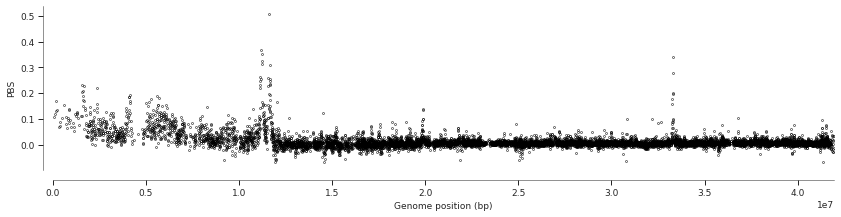

In [17]:
fig, ax = plt.subplots(figsize=(14, 3))
sns.despine(ax=ax, offset=10)
ax.plot(x, pbs, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
ax.set_xlabel('Genome position (bp)')
ax.set_xlim(0, pos.max())
ax.set_ylabel('PBS');


In [96]:
x[pbs >0.30]

array([11187744. , 11213744. , 11230354.5, 11244410.5, 11606622. ,
       11645422.5, 33284220.5])

In [108]:
pos['3L'].index(4)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

Found these genes on vectorbase:
   - Gene: TEP3 AGAP010816 , region 11,215,193-11'220'113 (11,203,978 11,228,496)
   - Gene: AGAP010817, region 11,241,256-11,260,276 (11,243,170)
   - Gene: TEP9 AGAP010830, region 11,595,490-11,600,414 (11,603,484)
   - No genes (11,647,583)
   - Gene: CLIPA2 AGAP011790, region 33,279,935-33,281,894 (33,281,581)